#### Механизмы статистического вывода

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from theano import tensor as tt

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.3.3
numpy     : 1.19.2
arviz     : 0.11.1
seaborn   : 0.11.1
pymc3     : 3.10.0
scipy     : 1.5.2
pandas    : 1.1.4
theano    : 1.0.11



__inference engines__ - это методы Монте-Карло, различные вариационные алгоритмы.

Байесовские методы теоретически просты, но с математической и вычислительной точки зрения это не так.
Главная причина - предельное правдоподобие (marginal likelihood, evidence), знаменатель в теореме Байеса, обычно принимает форму трудоемкого для вычисления интеграла.

Методы численной оценки предельного правдоподобия:

* Немарковские:
    * Grid-вычисления
    * Квадратичные аппроксимации
    * Вариационные методы
    
* Марковские:
    * Metropolis-Hastings
    * Hamiltonian Monte Carlo
    * Sequential Monte Carlo

---

#### Немарковские методы


__1.Grid-вычисления или вычисления по сетке:__

1. Определение разумно обоснованного интервала для параметра (априорное распределение должно дать подсказку).
2. Разместить решетку (сетку) по точкам (в общем случае – на равных расстояниях) в выбранном интервале.
3. Для каждой точки в решетке (сетке) перемножить правдоподобие и априорное распределение (вероятность).
4. Опционально - нормализация полученных точек их суммой.

Пример:

In [3]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """
    A grid implementation for the coin-flipping problem
    """
    # Define your grid
    grid = np.linspace(0, 1, grid_points)
    # Uniform prior
    prior = np.repeat(1/grid_points, grid_points) 
    # Probability mass function
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

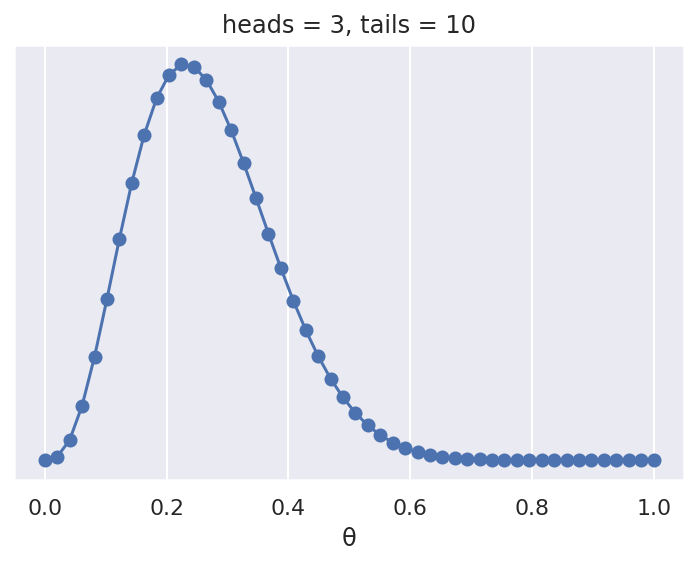

In [4]:
data = np.repeat([0, 1], (10, 3))
points = 50
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t)

plt.plot(grid, posterior, 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

Недостаток: плохо масштабируется при росте числа параметров.

Общая проблема: при увеличении числа параметров область пространства параметров, где сконцентрирована большая часть апостериорного распределения, становится все меньше и меньше по сравнению с объемом выборок данных.
(curse of dimensionality, concentration of measure).
Например:

* При увеличении числа измерений евклидово расстояние между любой парой элементов выборки постоянно уменьшается.
* В гиперкубе большая часть объема (данных) сосредоточена в его углах, а не в середине. В гиперсфере большая часть объема (данных) сосредоточена на ее поверхности, а не в середине;
* При высоких размерностях основная масса многомерного гауссова распределения не находится близко к среднему значению (или к моде), а расположена в окружающей оболочке (shell), которая перемещается от среднего значения к хвостам при увеличении размерности. Эта оболочка получила название типового множества (typical set).

Таким образом, грид-вычисления не слишком полезны в качестве общего метода решения задач с высокими размерностями.

#### 2.Квадратичная аппроксимация (метод Лапласса)

Это аппроксиация апостериорного распределения $p(x)$  гауссовым $q(x)$ с шагами:

1. Нахождение моды апостериорного распределения - среднего для $q(x)$
2. Вычисление матрицы Гессе (гессиана). По этой матрице можно вычислить стандартное отклонение для $q(x)$.
Т.е. можно приблизительно вычислить стандартное отклонение для $q(x)$, оценивая кривизну моды/среднего значения $q(x)$. Это можно сделать, вычислив значение, обратное квадратному корню из матрицы Гессе. Матрица Гессе –
это матрица второй производной функции, а обратная ей матрица позволяет получить ковариационную матрицу.

In [5]:
with pm.Model() as normal_approximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/theano/gpuarray/dnn.py:196: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  "Your cuDNN version is more recent than "


In [6]:
print(mean_q['p'], std_q)

0.2307692326802862 [0.11685454]


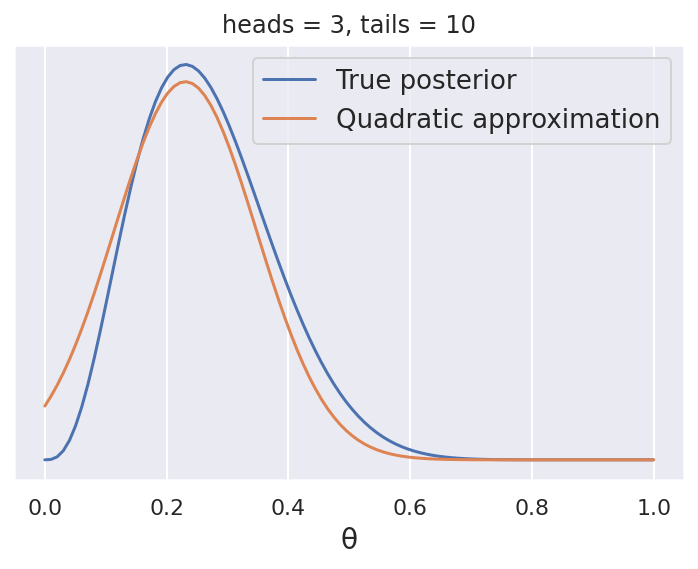

In [7]:
# analytic calculation
x = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(6, 4))
plt.plot(x, stats.beta.pdf(x , h+1, t+1), label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)
plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([]);

Таким образом, квадратичная аппроксимация - хороший метод для низкой размерности. 
Он не работает в случае ограниченных распределений (HalfNormal...), однако ограничения можно снять с помощью логарифмирования.

####  3.Вариационный метод


Имеет более развитую идею аппроксимации апостериорного распределения, как и в методе квадратичной аппроксимации.
Предлагается аппроксимировать апостериорное распределение $q(\theta)$ с помощью $p(\theta|y)$, минимизируя близость между ними. Под близостью понимается некоторая мера между рапсределениями. Общераспространенной близостью служит расхождение Кульбака-Лейблера, не является мерой расстояния в полном смысле слова (не выполняется неравенство треугольника):

$$D_{KL}(q(\theta)||p(\theta|y))=\int {q(\theta)log \frac{q(\theta)}{p(\theta|y)}} d\theta,$$

$q-$ вариационное распределение


$$D_{KL}(q(\theta)||p(\theta|y))=-\int{q(\theta) log \frac{p(\theta|y)}{q(\theta)}}d\theta + log(p(y)), D_{KL} \ge 0$$


$D_{KL} \ge 0, log(p(y))-$ const 

$-\int{q(\theta) log \frac{p(\theta|y)}{q(\theta)}}d\theta-$ ELBO, evidence lower bound

$D_{KL} \rightarrow min <=> -\int{q(\theta) log \frac{p(\theta|y)}{q(\theta)}}d\theta \rightarrow max$


Одним из возможных вариантов решения является предположение о том, что многомерное апостериорное распределение можно описать независимыми одномерными распределениями:

$$q(\theta) = \prod_{j}q_{j}(\theta_{j})$$


a.k.a __mean-field approximation__

В общем случае $q_{j}$ выбирают из семейства экспоненциальных распределений из-за простоты работы.


Недостаток: необходимость разработки специализированного алгоритма для каждой модели. Не существует универсального метода реализации механизма статистического вывода, но вместо него можно
предложить способ генерации методов, ориентированных на конкретные модели и требующих вмешательства пользователя.

Недавно предложен метод вариационного статистического вывода с применением автоматического
дифференцирования (__Automatic Differentiation Variational Inference – ADVI__)
(см. http://arxiv.org/abs/1603.00788). С теоретической точки зрения этапы выполнения метода ADVI выглядят следующим образом:
* Выполняется преобразование всех связанных распределений, чтобы расположить их на прямой действительных чисел, как это было сделано по методу Лапласа;
* Выполняется аппроксимация несвязанных параметров с использованием гауссова распределения (это член $q_j$). Гауссово распределение в преобразованном пространстве параметров не являлось гауссовым в исходном пространстве параметров;
* Применение автоматического дифференцирования для максимизации ELBO.

Примеры с ADVI: https://docs.pymc.io/pymc-examples/examples/variational_inference/bayesian_neural_network_advi.html

---

#### Марковские методы

Методы MCMC способны получать больше выборок из областей с более высокой вероятностью, чем из областей с более низкой вероятностью. В действительности любой метод MCMC будет посещать каждую область пространства параметров в соответствии с их относительными вероятностями.

На теоретическом уровне математической статистики достаточно знать метод вычисления ожидаемых значений, например:

$$\mathbb{E}[f]=\int_{\theta}{p(\theta)f(\theta)}d\theta$$


С MCMC это матожидание аппроксимируется асимптотически, т.е. с ростом числа выборок:

$$lim_{N \rightarrow \infty} \mathbb{E}_{\pi}[f] = \frac{1}{N}\sum_{n=1}^{N}{f(\theta_{n})}$$

Соответственно, хотелось бы, чтобы сходимость была быстрее, и количество генерируемых выборок требовалось меньше.

#### Briefly behind MCMC


#### Monte Carlo

Методы Монте-Карло – это весьма обширное семейство алгоритмов, использующих случайные выборки для вычисления или имитации заданного процесса. Один из создателей MCMC подхода является __Stanisław Marcin Ulam__. Аналитически невозможные или сложные задачи __Stanisław Marcin Ulam__ предложил решать методом генерации выборок из реализаций событий.

Учебный пример - оцена числа $\pi$:

1. Генерация N случайных точек на квадрате со стороной 2R
2. Вписывание окружности радиуса R в квадрат, подсчитать число точек, попавших в окужность $N_{in}$.
3. Получается:\
   Вписанная окружность: $S_{square}=(2R)^2$\
   Квадрат:              $S_{circle}=\pi R^2$\
   Отношение площадей: $\frac{S_{circle}}{S_{square}} = \frac{\pi R^2}{4R^2} = \frac{\pi}{4}$
   
   Значит, нужно оценить соотношение площадей (в нашем случае - реализацией точек на площадях) с коэффициентом:\
   $$\hat{\pi}=4\frac{N_{in}}{N}$$

Замечания:
1. Площади круга и квадрата пропорциональны количеству точек внутри окружности и общему количеству точек $N$ соответственно.
2. Известно, что любая точка находится внутри окружности, если выполняется: $\sqrt{x^2+y^2} \le R$

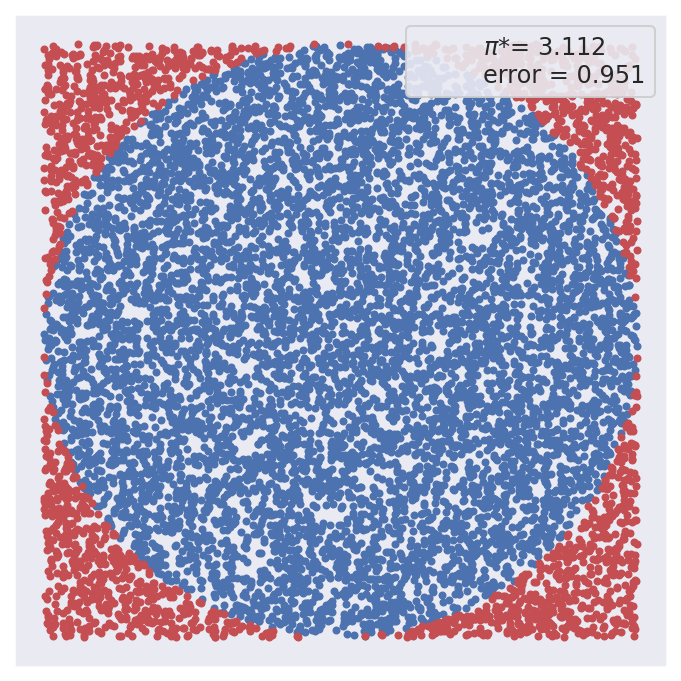

In [8]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
outside = np.invert(inside)


plt.figure(figsize=(6, 6))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'$\pi$*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)

plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9,  fontsize=12);

#### Markov chain

- это математический объект, состоящий из последовательности состояний и набора вероятностей переходов, который описывает, как выполняются переходы между состояниями.


Цепь является __марковской__, если вероятность перехода в любое другое состояние зависит только от текущего состояния.

Если каким-либо образом найти цепь Маркова с вероятностями переходов, пропроциональным распределению, которое требуется для выборки (в байесовском анализе это апостериорное распределение), то процедура выборки превращается в простые перемещения между состояниями в такой цепи.

Сложность: найти такую цепь, если апостериорное распределение заранее неизвестно.

В большинстве методов есть условие __детального равновесия (detailed balance condition)__:

Условие __не является необходимым, оно достаточное__.

В соответствии с этим принципом мы должны перемещаться по обратимому (реверсивному) пути.
Таким образом, вероятность пребывания в состоянии $i$ и перехода в состояние $j$ должна быть равной вероятности пребывания в состоянии $j$ и перехода в состояние $i$.

Если удалось создать цепь Маркова, соответствующую принципу детального равновесия, можно сформировать выборку из этой цепи с гарантией того, что мы будем получать выборки из правильного распределения.

#### 1.Metropolis-Hastings


Алгоритм Метрополиса–Гастингса позволяет получать выборки из любого распределения $p(x)$, предоставляя возможность вычислять, по крайней мере, значение, пропорциональное распределению, без учета фактора нормализации.

Общий вид алгоритма:

1. Выбрать начальное значение для параметра, $x_i$. Случайно или на основе предположения.
2. Выбрать новое значение параметра $x_i$, семплируя из удобного распределения, например, нормального $q \sim N(\mu,\sigma)$ или равномерного $q \sim U(a, b)$, $q(x_{i+1}|x_i)$. Шаг соответствует смене состояния  $x_i$.
3. Расчет вероятности принятия нового состояния:
$$p_a(x_i+1|x_i)=min(1, \frac{p(x_{i+1})q(x_i|x_{i+1})}{p(x_i)q(x_{i+1}|x_i)})$$

4. Получаем $r \sim U(0, 1)$, если $p_a(x_i+1|x_i) > r$, принимаем и записываем новое состояние $x_{i+1}$, иначе остаемся в старом состоянии $x_i$. 

5. Возврат к шагу 2. до момента останова по заданному числу итераций.

Если распределение предложений новых состояний (proposal distribution) $q(x_{i+1}|x_i)$ - симметричное, то получаем критерий Метрополиса:

$$p_a(x_i+1|x_i)=min(1, \frac{p(x_{i+1})}{p(x_i)})$$


При выполнении шагов 3 и 4 предполагается, что мы всегда будем принимать переход в наиболее вероятное состояние. Менее вероятные значения параметра принимаются по вероятностному принципу, с учетом отношения между вероятностью значения нового параметра $x_{i+1}$ и вероятностью значения старого параметра $x_i$.


Целевое распределение (апостериорное распределение в байесовской статистике) аппроксимируется списком значений параметров из выборки. Если значение принимается, то  $x_{i+1}$ добавляется в список новых значений выборки. Если значение не принято, то добавляется $x_{i}$.

Эффективность семплинга, что очевидно, зависит от proposal distribution.
В общем случае, proposal distribution - многомерное номральное распределение $q \sim N(M, \Sigma)$,  в котором  ковариационная матрица $\Sigma$ оценивается вначале при __tuning__.

Эмпирический трюк - использование __burn-in step__. Подход состоит в удалении части первых получаемых выборок, поскольку необходимо некоторое время, прежде чем семплирование начнется из целевого распределения.


В конце семплинга получаем список значений - оценку апостериорного распределения.

Игрушечный пример:

In [9]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5 # func.mean()
    old_prob = func.pdf(old_x)
    
    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x
    return trace

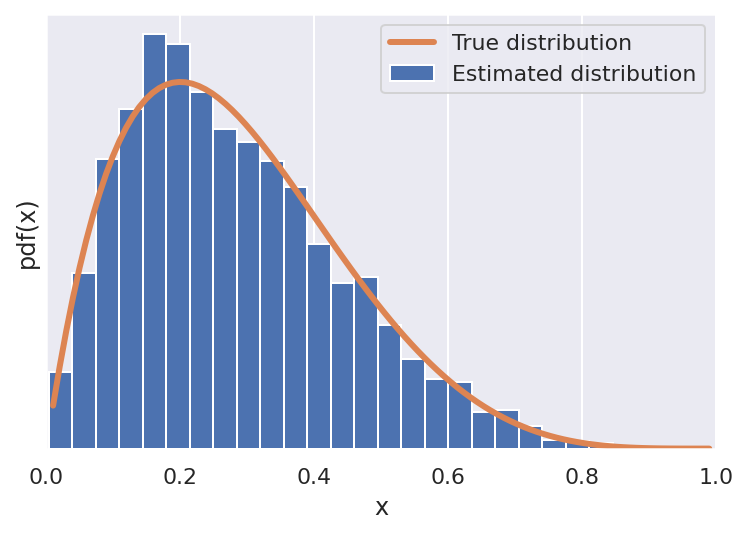

In [10]:
np.random.seed(3)

func = stats.beta(2, 5)
trace = metropolis(func=func)

x = np.linspace(0.01, .99, 100)
y = func.pdf(x)

plt.xlim(0, 1)
plt.plot(x, y, 'C1-', lw=3, label='True distribution')
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution')

plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend()
plt.show()

#### 2.Hamiltonian Monte Carlo

Теоретическое обоснование получения хороших в смысле информативных выборок из апостериорного рапсределения для Metropolis-Hastings основывается на необходимости проведении большого, иногда крайне значительного количества итераций.

Одна из широко используемых альтернатив MH - __HMC, Hamiltonian Monte Carlo (Hybrid Monte Carlo)__, применяет в себе концепции статистической механики - Гамильтониан, содержащий описание общей энергии физической системы. HMC может быть альтернативной для бытсрого исследования пространства параметров (Neal, 2011).

HMC схож с MH, но __перемещения из одного состояния в другое не случайны__. Гамильтова механика описывает, как объект в локации $\theta$ с ускорением $M$ в момент времени $t$ будет двигаться. Его движение определяется сумммой кинетической $K(M)$ и потенциальной энергии $U(\theta)$, сумма которых - постоянна:

$$E(\theta, M) = U(\theta) + K(M)$$

Используем функциональную форму скорости падения энергии с точки зрения теории вероятностей:

$$P(E_i)\propto e^{-E_i / T},$$

$E_i-$ энергитический уровень, $T-$ температура,

Предположим, апостериорное распределение для оценки - $\Pi(\theta),$


$$\Pi(\theta, M) \propto e^{-E(\theta, M) / T}=e^{-( U(\theta) + K(M) ) / T},$$

Предположим, что T=1:

$$\Pi(\theta, M) \propto e^{-U(\theta) - K(M)}$$

При этом:

$$U(\theta)=-log[P(x|\theta)P(\theta)]=-log\Pi(\theta),$$

$$K(M)=\sum_{i=1}^{D} {\frac{mass M_i^2}{2}},$$

Предположим, $mass=1:$

$$K(M)=\sum_{i=1}^{D} {\frac{M_i^2}{2}} = \frac{M^2}{2},$$

Значит:

$$\Pi(\theta, M) \propto e^{log\Pi(\theta)} e^{-\frac{M^2}{2}}=\Pi(\theta)e^{-\frac{M^2}{2}}=\Pi(\theta)N(M|0, 1)$$

Заметим:

$$\int{\Pi(\theta, M)}dM = \frac{1}{z}P(x|\theta)P(\theta) \int{N(M|0,1)}dM,$$
$$\int{N(M|0,1)}dM=1$$  => маригинальное распределение $\Pi(\theta)-$ также и апостериорное $\Pi(\theta, M):$

$$\int{\Pi(\theta, M)}dM = \Pi(\theta)=\frac{1}{z}P(x|\theta)P(\theta)$$

Пусть  $\theta=(\theta_1, ..., \theta_d), M=(M_1, ..., M_d),$ получаем уравнения Гамильтона:

$$\frac{d\theta_i}{dt}=\frac{dH}{dM_i}, \frac{dM_i}{dt} = \frac{dH}{d\theta_i}$$

Для имплементации Гамильтовой динамики, необходима дискретизация системы дифференциальных уравнений. Это осуществляется алгоритмом __leapfrog__.

Перемещение в соответствии с кривизной пространства параметров в HMC превращается в более осмысленный способ иследования этого пространства. Тем не менее, в HMC в рамках leapfrog-алгоритма уже необходимо считать градиенты.

Современная имплементация HMC - __No-U-Turn Sampler (NUTS)__. Недостаток NUTS - работает только с непрерывными распределениями.

Интерактивыне примеры алгоритмов семплинга: https://chi-feng.github.io/mcmc-demo/

#### 3.Sequential Monte Carlo


Недостаток HM, HMC- при наличии мултимодальных распределений, в которых пики разделены низкой плотностью вероятности, высока вероятность алгоритмов застрять только на одной пике.


Многие из методов, разработанных для устранения проблемы многочисленных минимумов, основаны на идее применения __температуры__, что также заимствовано из статистической механики.

Количество состояний, которые может принимать физическая система, зависит от температуры этой системы – при 0 градусов Кельвина (самая низкая возможная температура) любая система «застывает» в единственном состоянии. В другом предельном случае, при бесконечно высоких температурах все возможные состояния системы равновероятны.

В целом, нас интересуют системы при некоторых средних температурах:

$$p(\theta|y)_\beta \propto p(\theta|y)^{\beta}p(y),$$

$\beta-$ инверсия температуры

Соответственно, поскольку семплировать из распределения, более близкого к априорному при $\beta \rightarrow 0$ проще, то возникает интересный вариант семплинга из все более усложняющегося распределения с ростом $\beta$.

__SMC__ - один из методов, использующих эту идею. Алгоритм:

1. Инициализация $\beta=0$
2. Семплинг N значений $S_\beta$ из обобщенного(или так сказать "нагреваемого") распределения.
3. $\beta+=\delta$
4. Вычисление $N$ весовых коэффициентов $W$ на основе нового распределения.
5. Получение $S_W$ с помощью повторной выборки $S_\beta$ c весами $W$.
6. Запуск $N$ цепей алгоритма Метрополиса, каждую из которых начиная с разных элементов выборки $S_W$
7. Повторение с начала пункта 2., пока $\beta \le 1$.


Эффективность температурного метода в высокой степени зависит от промежуточных значений $\beta$, которые обычно обозначают термином «планирование охлаждения» (cooling schedule, из алгоритма имитации отжига). Чем меньше разность между двумя последовательными значениями $\beta$, тем ближе два последовательно вычисляемых смешанных апостериорных распределения, следовательно, тем проще будет переход из текущего состояния в следующее. Но если шаг последовательного увеличения значений слишком мал, то потребуется много промежуточных состояний, и в некоторый момент процесс превратится в расточительство вычислительных ресурсов без реального улучшения
точности результатов.

SMC позволяет автоматически вычислять промежуточные значения $\beta$. Точное «планирование охлаждения»
адаптируется к сложности задачи, то есть распределения, которые более сложны для извлечения выборок, потребуют больше промежуточных состояний, чем простые распределения.


Кроме промежуточных значений $\beta$, динамически вычисляются еще два параметра, основанных на интенсивности принятия предыдущего состояния: число шагов каждой цепи Маркова и ширина proposal distribution.

---

#### Диагностика получаемых выборок

Поскольку апостериорное распределение аппроксимируется конечным числом генерируемых выборок, важно оценивать качество этих выборок. 


Типы анализа:

* Визуальный
* Количественный, с использованием метрик.

Особенность этого анализа также в том, что мы не знаем, действительно правильное апостериорное распределение было найдено. Мы можем только сказать, насколько качественные поулчаются выборки. И это качество необходимо оценивать с нескольких сторон.

Шаги при индикации проблем:

1. Увеличение числа итераций семплинга
2. Использование эмпирического Burn-in
3. Изменение параетров самого алгоритма семплинга
4. Изменение модели
5. Трансформация данных (центрирование, стандартизация и т.д.)

In [37]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)
    b_shift = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_shift * a)
    trace_ncm = pm.sample(2000, random_seed=7)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5325273489110282, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWa

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


#### 1.Сходимость MCMC


Для алгоритма семплинга неоходимо некоторое время для сходимости к целевому апостериорному рапсределению, из которого будут генерироваться надежные выборки.

* Сходимость можно оценить с помощью графиков трассировки цепей (trace plots):
https://colab.research.google.com/github/OriolAbril/oriol_unraveled/blob/master/_notebooks/2020-06-20-plot-trace.ipynb

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

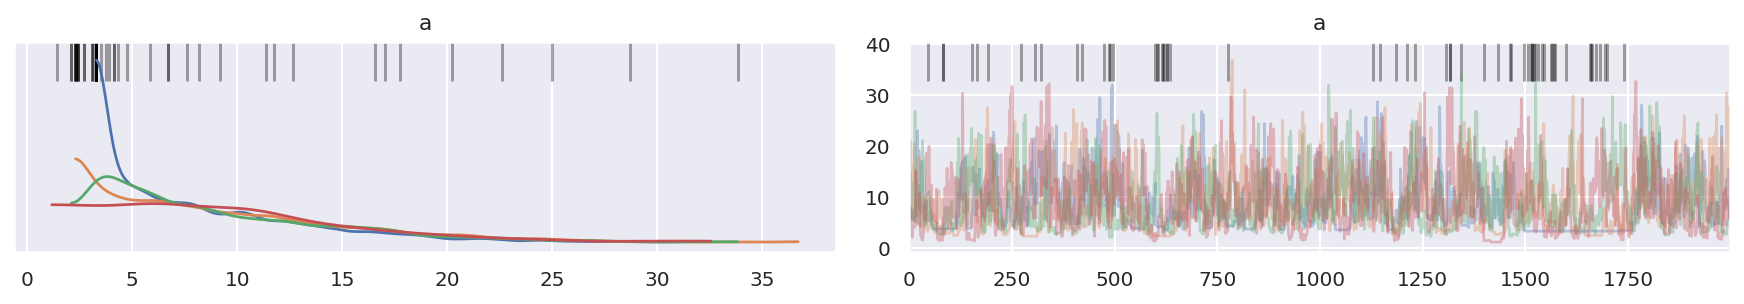

In [38]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top', compact=False)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

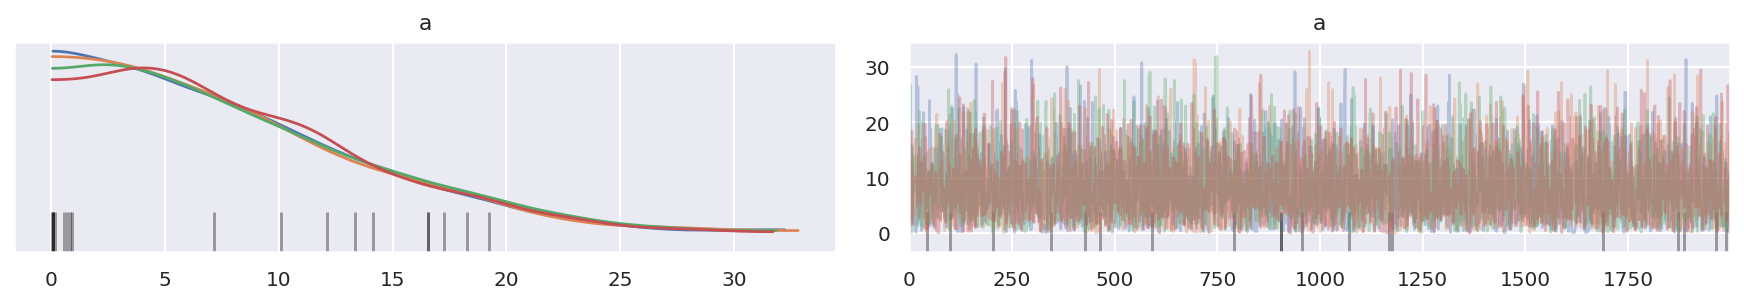

In [39]:
az.plot_trace(trace_ncm, var_names=['a'], compact=False)

Гладкость KDE - хороший признак, негладкая кривая KDE может свидетельствовать о некоторой проблеме, например о необходимости увеличения числа элементов выборки или о более серьезной проблеме.

Трассировка (trace) должна выглядеть как белый шум, не должно быть каких-либо визуально распознаваемых паттернов. Когда наблюдается именно такая картина, то получено качественное смешивание (good mixing). Плохое смешивание можно наблюдать в trace_cm.

* Сходимость можно оценить со статистикой Rhat, которая оценивается как соотношение дисперсий между цепями и в самих цепях. При хорошем смешении статистика должна быть 1-1.1.

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

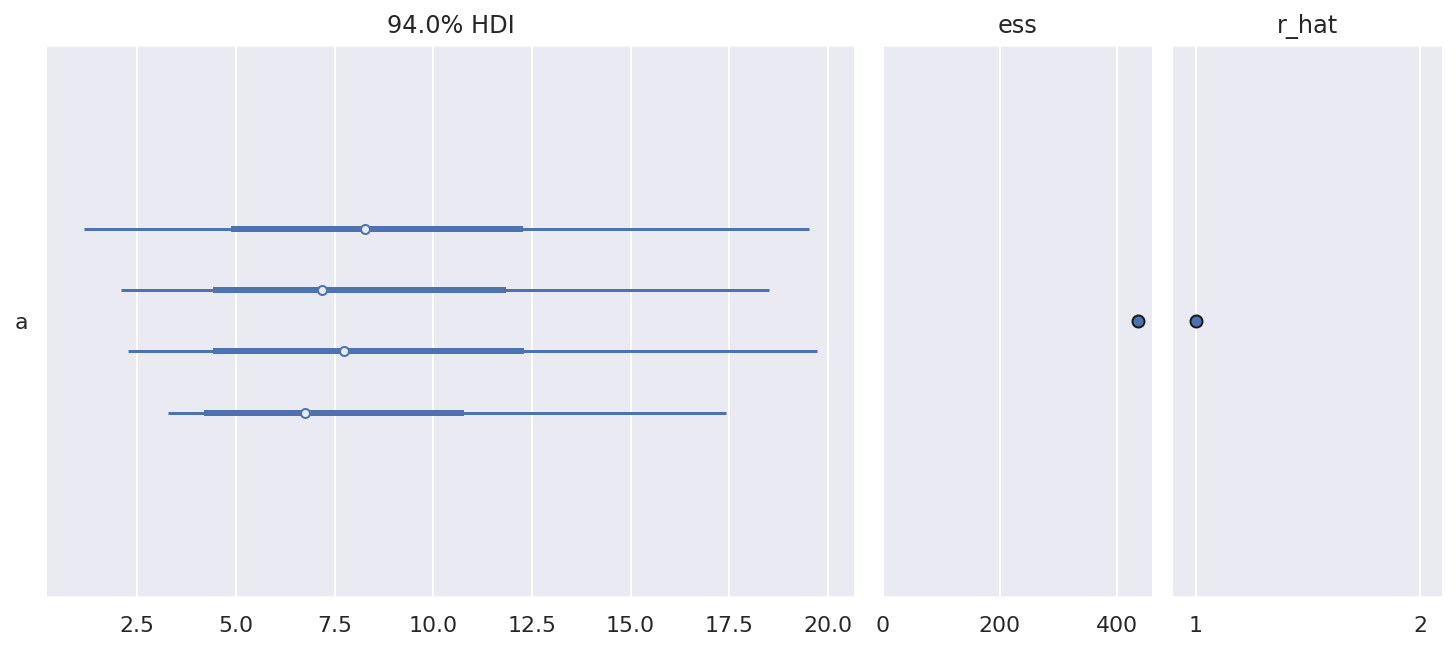

In [40]:
az.plot_forest(trace_cm, var_names=['a'], r_hat=True, ess=True)

In [41]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
centered,8.791,5.466,1.364,18.982,0.261,0.184,440.0,440.0,339.0,356.0,1.0
non_centered,8.151,6.045,0.005,19.053,0.077,0.055,6085.0,6085.0,4499.0,2613.0,1.0


#### 2.Monte Carlo ошибка


$$mc_{error} = \frac{\sigma(x)}{\sqrt{n}},$$

$mc_{error}-$ стандартная ошибка среднего $x$ из $n$ блоков, где блок-  доля семплированных значений в трассировке. Эта ошибка должна быть меньше точности, которую мы требуем от получаемых результатов.



#### 3.Автокорреляция

В идеальном случае выборка из распределения, в том числе и из апостериорного распределения, должна иметь автокорреляцию, равную нулю (если только корреляция не является ожидаемой, например во временных рядах). Выборка считается автокоррелированной, если значение на какой-либо произвольно выбранной итерации не является независимой от значений выборки на других итерациях. 

На практике выборки, сгенерированные методами MCMC, будут автокоррелированными, особенно при использовании алгоритма Метрополиса–Гастингса и в меньшей степени NUTS и SMC.

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>,
       <AxesSubplot:title={'center':'a\n2'}>,
       <AxesSubplot:title={'center':'a\n3'}>], dtype=object)

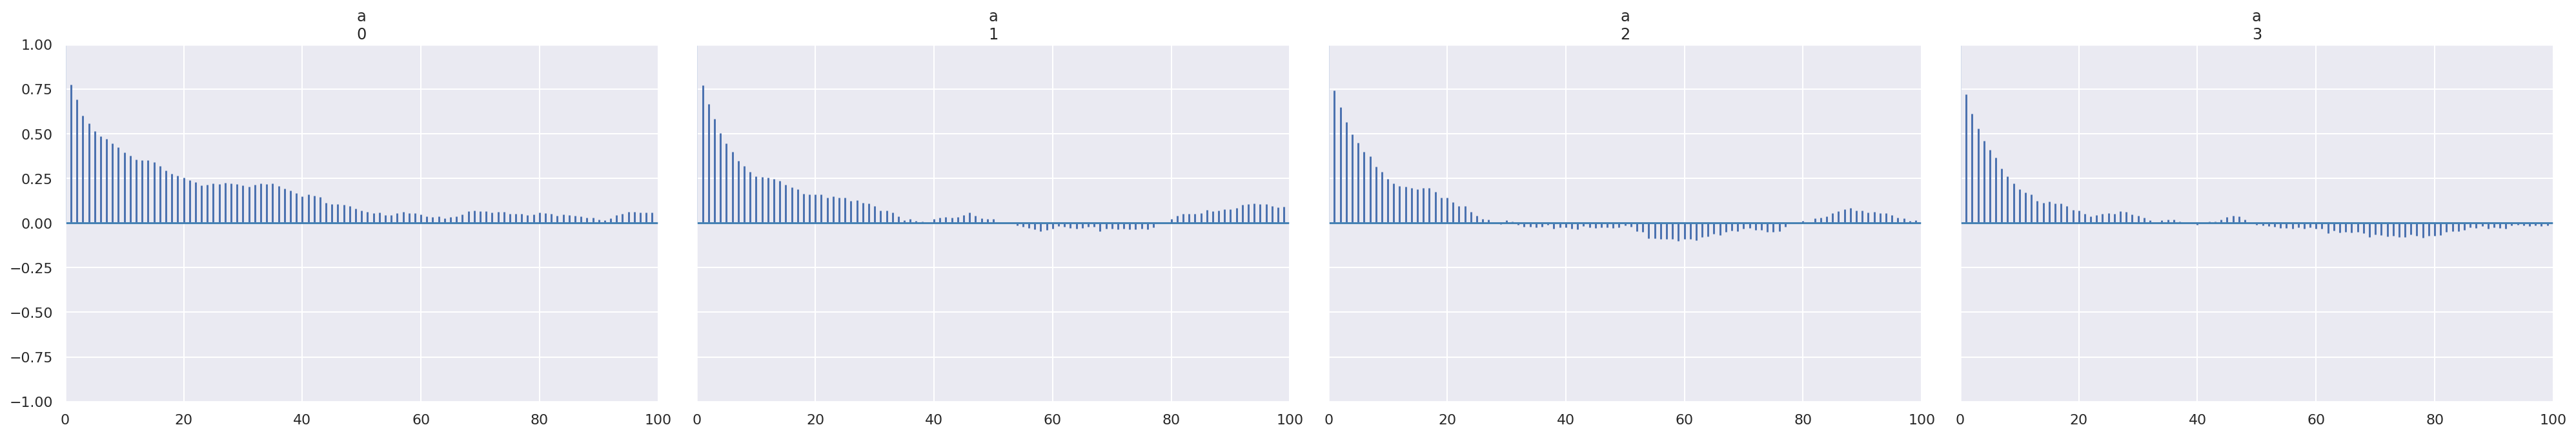

In [42]:
# Наличие автокорреляции
az.plot_autocorr(trace_cm, var_names=['a'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>,
       <AxesSubplot:title={'center':'a\n2'}>,
       <AxesSubplot:title={'center':'a\n3'}>], dtype=object)

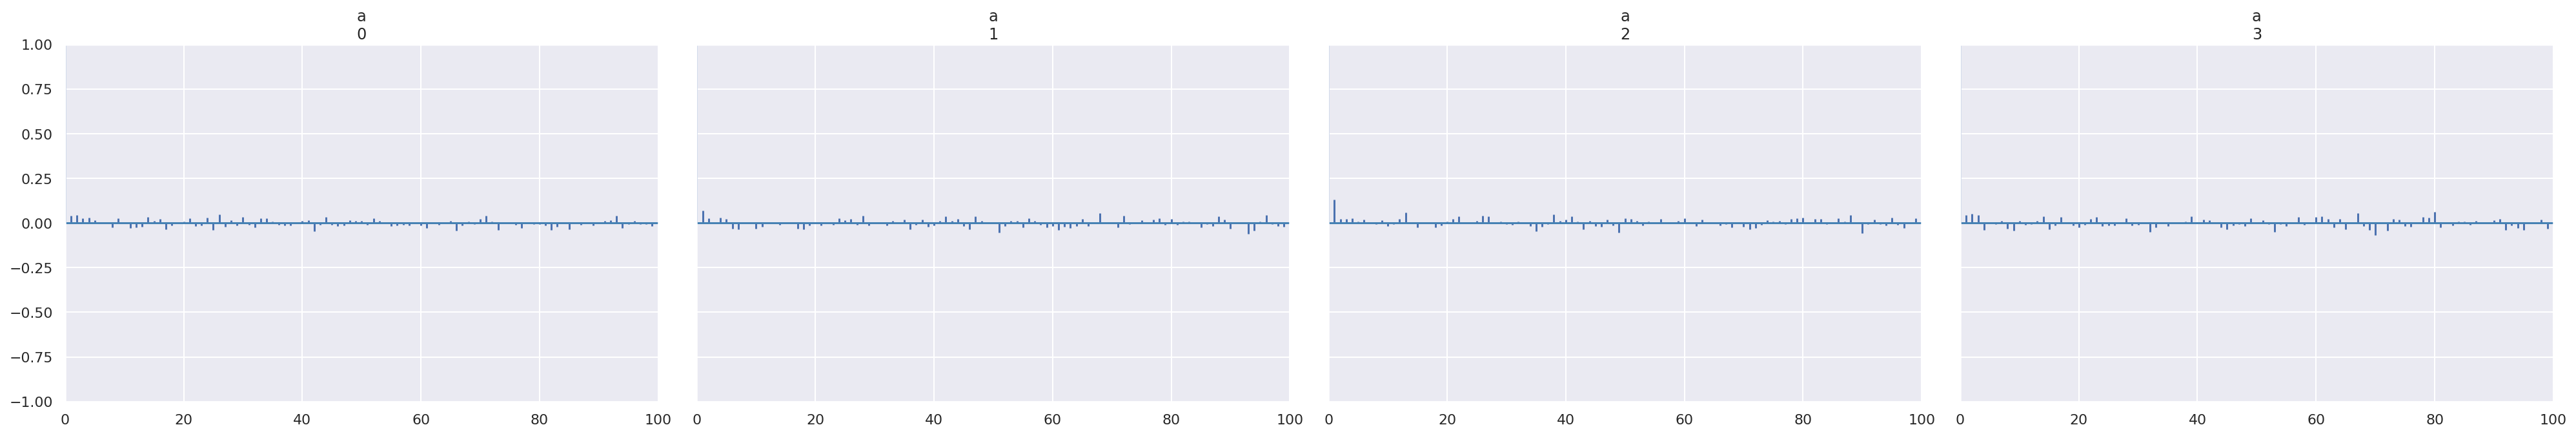

In [43]:
# Отсутствие автокорреляции
az.plot_autocorr(trace_ncm, var_names=['a'])

#### 4.Эффективный размер выборки

Выборка с автокорреляцией содержит меньше информации, чем выборка того же размера без автокорреляции. В действительности можно использовать автокорреляцию для оценки размера некоторой произвольной выборки с равнозначной информацией, но без автокорреляции. Это называется эффективным размером выборки.


Чем больше автокорреляция параметра, тем большее количество выборок потребуется для получения заданной точности, иначе говоря, автокорреляция оказывает негативное воздействие, снижая количество эффективных элементов выборки.


В идеальном случае эффективный размер выборки должен быть как можно более близким к реальному размеру выборки.


Если необходима высокая точность количественных характеристик, которые зависят от хвостов распределения или чрезвычайно редких событий, то потребуется увеличение эффективного размера выборки.

#### 5.Дивергенции или расхождения 

Тесты расхождений возможны исключительно для механизма NUTS, поскольку они основаны на внутренней
работе метода, и не являются свойством генерируемых выборок. Тесты основаны на так называемых расхождениях (divergences) и представляют собой мощный и достаточно точный метод диагностирования выборок.

Расхождения могут свидетельствовать о том, что механизм NUTS обнаружил в апостериорном распределении области с сильной кривизной, которые невозможно обработать корректно. Это говорит о том, что механизм выборки мог пропустить область пространства параметров, поэтому результаты будут искажены.
Тесты расхождений могут сообщать о проблемах, даже если все остальные тесты прошли успешно.

Расхождения обладают замечательным свойством: они обычно __появляются близко к проблематичным областям пространства параметров, следовательно, их можно использовать для идентификации возможной локации проблемы__.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/plots/pairplot.py:228: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument o

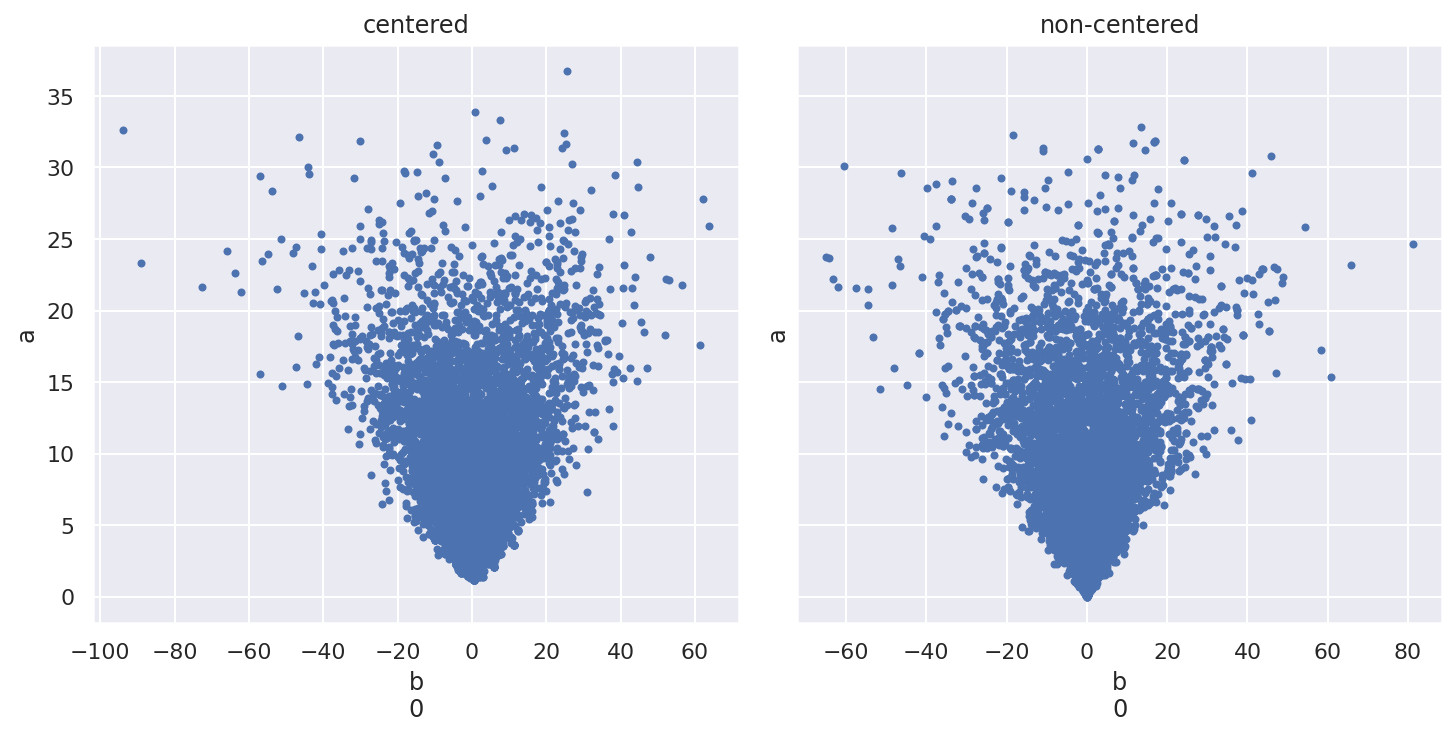

In [72]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, 
                 kind='scatter', divergences=True, contour=False, 
                 divergences_kwargs={'color':'C1'}, ax=ax[idx],

                )
    
    ax[idx].set_title(['centered', 'non-centered'][idx])
    
plt.show()

array([[<AxesSubplot:ylabel='theta\nDeerfield'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='theta\nChoate', ylabel='tau'>,
        <AxesSubplot:xlabel='theta\nDeerfield'>,
        <AxesSubplot:xlabel='mu'>]], dtype=object)

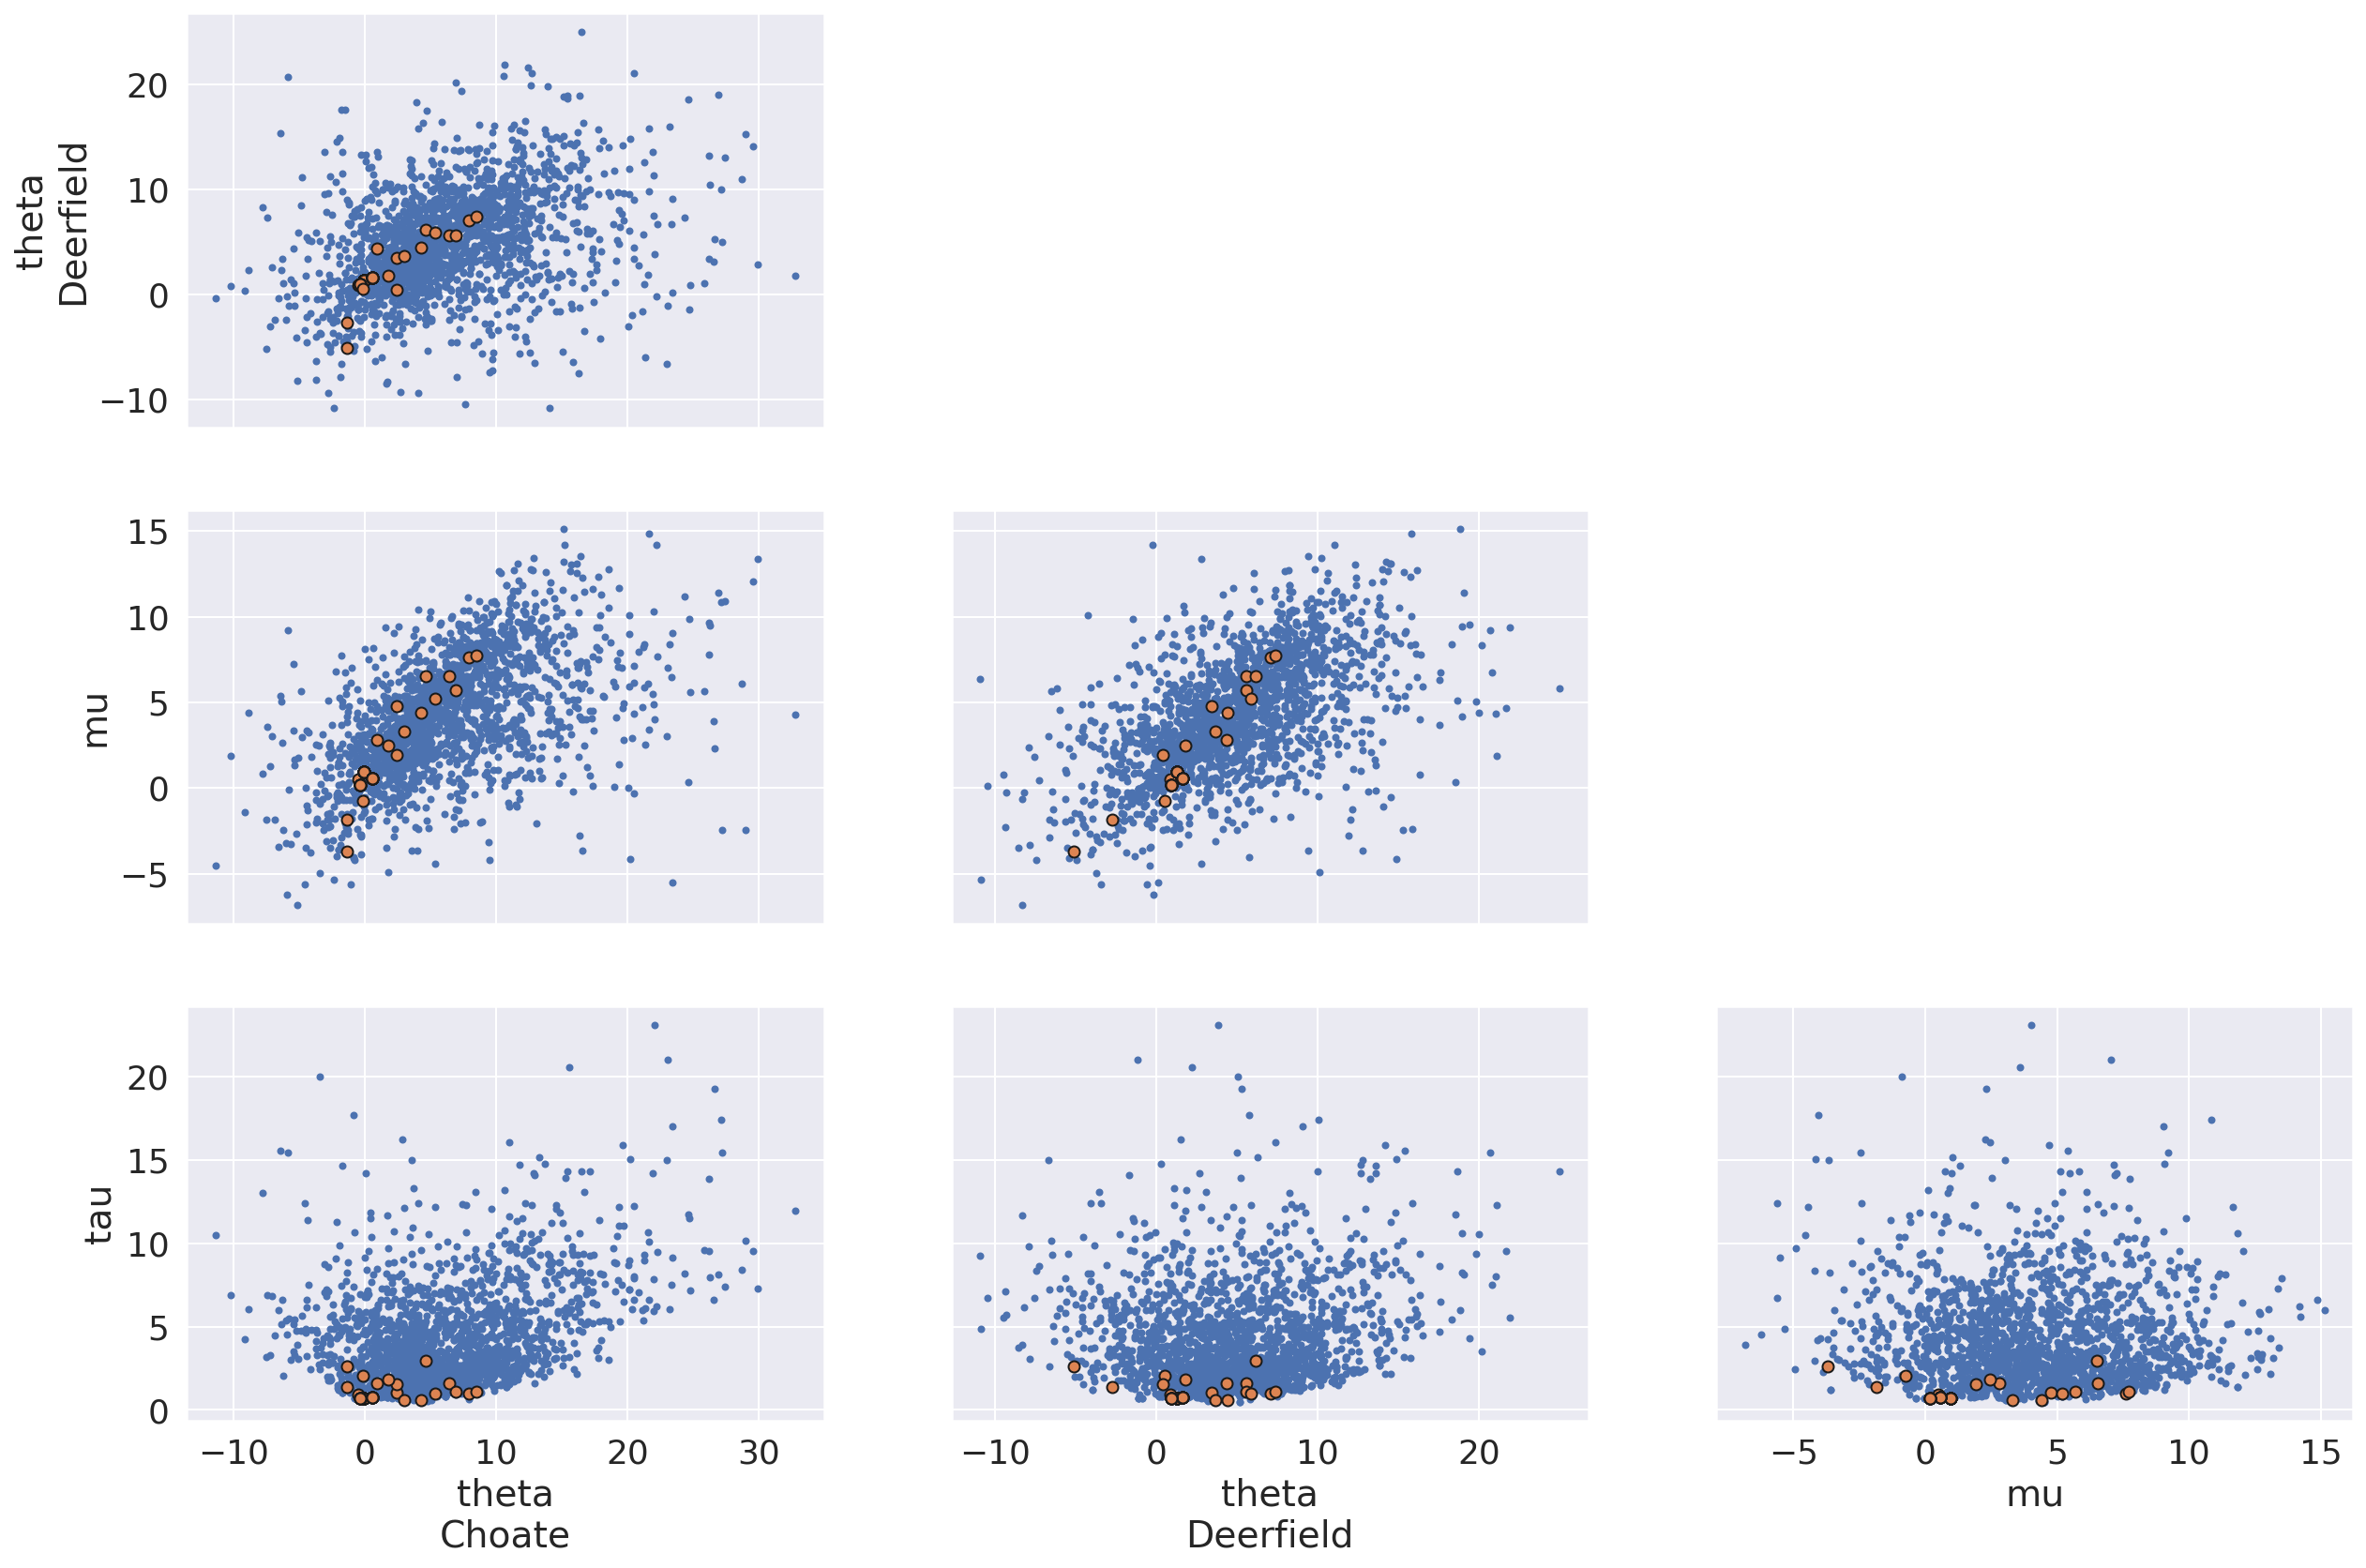

In [59]:
centered = az.load_arviz_data('centered_eight')
coords = {'school': ['Choate', 'Deerfield']}

az.plot_pair(centered,
            var_names=['theta', 'mu', 'tau'],
            kind='scatter',
            coords=coords,
            divergences=True,
            textsize=18)


Еще одним полезным способом визуального наблюдения расхождений является параллельная диаграмма:

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

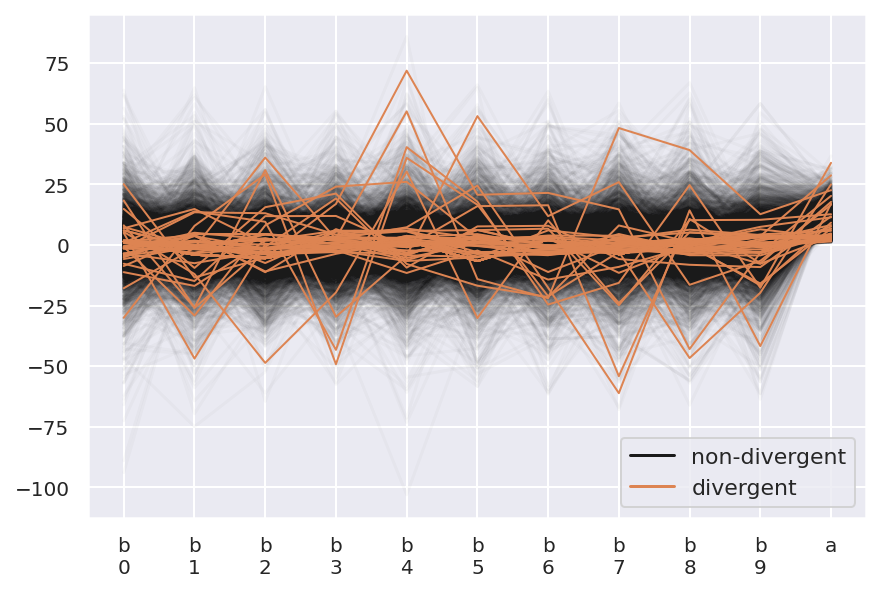

In [60]:
az.plot_parallel(trace_cm)

Здесь можно видеть, что расхождения сконцентрированы около 0 для обоих параметров a и b.

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

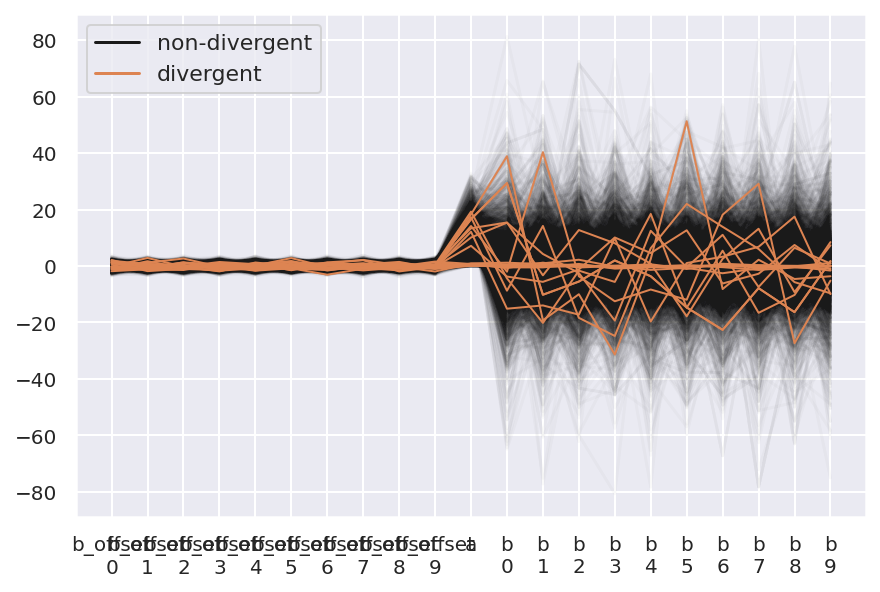

In [61]:
az.plot_parallel(trace_ncm)

Библиотека PyMC3 использует определенную эвристику для пометки расхождений, но иногда эта эвристика может сообщать о наличии расхождений там, где их в действительности нет. 

Общее правило: если расхождения рассеяны по пространству параметров, то, вероятнее всего, это ложноположительные случаи, но если расхождения расположены компактно (сконцентрированы в некоторой области), то это с большой вероятностью признак проблемы.

Общие способы избавления от этого:

* Увеличение числа шагов точной настройки, например `pm.sample(tuning=1000)`.
* Увеличение значения параметра `target_accept`, для которого по умолчанию установлено значение 0.8. Максимально возможное значение 1, поэтому можно попробовать значения 0.85 или 0.9.
* Изменение параметризации модели.